# 1. Configuración Inicial y Carga de datos

## 1.1 Importación de las librerías necesarias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

## 1.2 Carga y visualización de los datos

In [2]:
dataSet = pd.read_csv('Alcohol_Sales.csv')
dataSet.columns = ['date', 'sales']
# Se cambian las fechas a strings para que pandas pueda leerlos
dataSet['date'] = dataSet['date'].astype('str')
dataSet

,date,sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


# 2. Analalisis de los datos

## 2.1 División de datos train, test

Dividimos nuestro dataSet en entrenamiento y pruebas sin hacer shuffle dado que estamos trabajando con lineas de tiempo

In [3]:
trainData, testData = train_test_split(dataSet, test_size=0.2, shuffle=False)

## 2.2 Análisis de estacionariedad

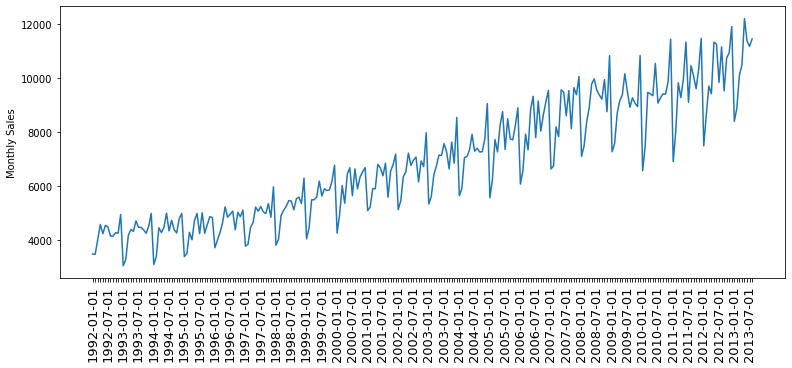

In [4]:
fig, ax = plt.subplots(figsize=(13, 5))

plt.plot(trainData['date'], trainData['sales'])
plt.xticks(rotation = 90,size=13)
plt.ylabel('Monthly Sales')

every_nth = 6
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

Como observamos en la gráfica de arriba nuestra serie de tiempo tiene una tendencia a ir hacia arriba por lo que podríamos concluir que no es una serie estacionaría pero podemos hacer los test Dickey-Fuller y KPS para confirmar.

In [5]:
def test_stationary(timeseries):

	rolmean = timeseries.rolling(window=12).mean()
	rolstd = timeseries.rolling(window=12).std()
	
	orig = plt.plot(timeseries, color='blue', label='Original')
	mean = plt.plot(rolmean, color='red', label='Rolling Mean')
	st = plt.plot(rolstd, color='black', label='Rolling Std')
	plt.legend(loc='best')
	plt.title('Rolling Mean & Standard Deviation')
	plt.show()

	#Dickey-Fuller:
	print('Results of Dickey-Fuller Test:')
	dftest = adfuller(timeseries)
	dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
	for key, value in dftest[4].items():
		dfoutput['Critical Value(%s)' %key] = value
	print(dfoutput)

	#KPSS:
	print('Results of KPSS Test:')
	kpsstest = kpss(timeseries, regression='c')
	kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
	for key, value in kpsstest[3].items():
		kpss_output['Critical Value (%s)' %key] = value
	print(kpss_output)

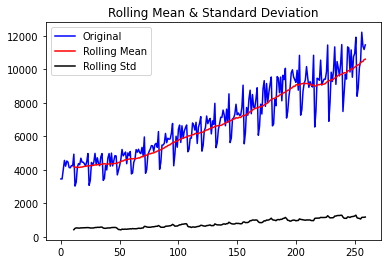

Results of Dickey-Fuller Test:
Test Statistic                   1.534774
p-value                          0.997648
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value(1%)              -3.457326
Critical Value(5%)              -2.873410
Critical Value(10%)             -2.573096
dtype: float64
Results of KPSS Test:
Test Statistic            2.468021
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [6]:
test_stationary(trainData['sales'])

Para poder comprobar si nuestra serie es estacionaria o no realizamos las pruebas Dickey-Fuller y KPSS las cuales nos dieron los valores de 0.997 y 0.01 respectivamente, estos indican que nuestra serie no es estacionaria.

## 2.1 Tratamiento de la serie
Vamos a tratar la serie para que sea estacionaria y que de esta forma nuestro modelo pueda predecir con mayor exatitud como se seguira comportando en el futuro

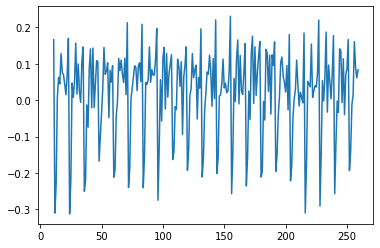

In [7]:
tslog = np.log(trainData['sales'])
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

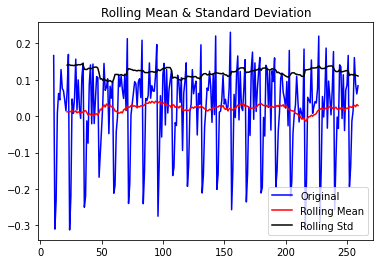

Results of Dickey-Fuller Test:
Test Statistic                  -3.531175
p-value                          0.007222
#Lags Used                      14.000000
Number of Observations Used    234.000000
Critical Value(1%)              -3.458608
Critical Value(5%)              -2.873972
Critical Value(10%)             -2.573396
dtype: float64
Results of KPSS Test:
Test Statistic           0.039888
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [8]:
test_stationary(tslogdiff)


Esta primer diferienciación nos sirvio para poder detectar que nuestra serie si se puede hacer estacionaria, ya que vimos que si se puede volveremos a diferenciar nuestra serie pero ahora con una funcion logaritmica

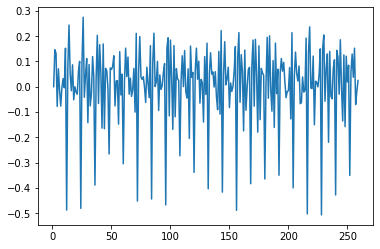

In [9]:
tslog = np.log(trainData['sales'])
logret= diff(tslog)
plt.plot(logret)
plt.show()

Ahora buscaremos las variables que tengan más correlación y volveremos a diferenciar una segunda vez para ver cómo cambian estos valores

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


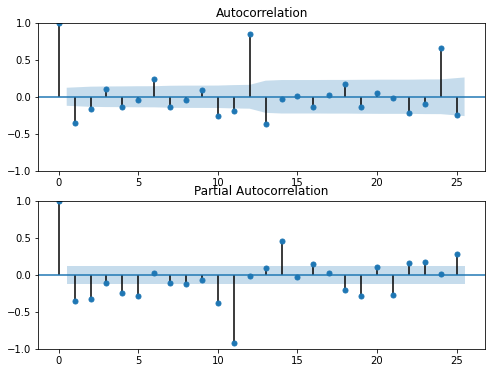

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(logret, ax=ax[0])
plot_pacf(logret, ax=ax[1])
plt.show()

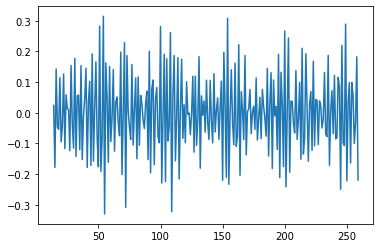

In [11]:
slogret= diff(diff(tslog), k_seasonal_diff=1, seasonal_periods=12)
plt.plot(slogret)
plt.show()

In [12]:
m = int(np.log(dataSet.shape[0]))
acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,229.421672,1.422833e-47


Podemos observar que nuestro p value todavía no es el deseado pero lo dejaremos así pues diferenciarlo una tercera vez no nos serviria ya que nuestra serie podría dejar de tener sentido, 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


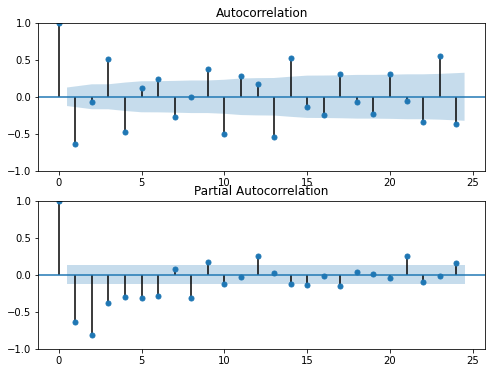

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(slogret, ax=ax[0])
plot_pacf(slogret, ax=ax[1])
plt.show()

In [14]:
pp = []
qq = []
PP = []
QQ = []
aic = []
lb = []
sse = []
for p in range(0,2):
    for q in range(0,2):
        for P in range(0,2):
            for Q in range(0,2):
                model=sm.tsa.statespace.SARIMAX(np.log(trainData['sales']),order=(p, 1, q),seasonal_order=(P,1,Q,12))
                res = model.fit()
                pp.append(p)
                qq.append(q)
                PP.append(P)
                QQ.append(Q)
                aic.append(res.aic)
                lb.append(acorr_ljungbox(res.resid, lags=[m]))
                sse.append((res.resid**2).sum())
            
resdf = pd.DataFrame()
resdf['p']=pp
resdf['q']=qq
resdf['PP']=PP
resdf['QQ']=QQ
resdf['AIC']=aic
resdf['lb-p-value']=lb
resdf['sse']=sse

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [15]:
resdf

,p,q,PP,QQ,AIC,lb-p-value,sse
0,0,0,0,0,-581.380470,lb_stat lb_pvalue 5 0.375112 0.995987,88.656807
1,0,0,0,1,-583.628482,lb_stat lb_pvalue 5 0.374621 0.996,88.643501
2,0,0,1,0,-584.710524,lb_stat lb_pvalue 5 0.362594 0.996298,88.627221
3,0,0,1,1,-629.699435,lb_stat lb_pvalue 5 0.332045 0.996997,88.404982
4,0,1,0,0,-773.277881,lb_stat lb_pvalue 5 0.169308 0.999409,87.920466
5,0,1,0,1,-782.195965,lb_stat lb_pvalue 5 0.174099 0.999368,87.905204
6,0,1,1,0,-772.015241,lb_stat lb_pvalue 5 0.167581 0.999424,87.918730
7,0,1,1,1,-822.568710,lb_stat lb_pvalue 5 0.162804 0.999463,87.807437
8,1,0,0,0,-677.945173,lb_stat lb_pvalue 5 0.206261 0.999045,88.208640
9,1,0,0,1,-690.580367,lb_stat lb_pvalue 5 0.204249 0.999067,88.164256


# 3. Modelo

In [16]:
model=sm.tsa.statespace.SARIMAX(np.log(trainData['sales']),order=(0, 1, 1),seasonal_order=(0, 1, 1, 12))
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  260
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 394.098
Date:                            Tue, 29 Nov 2022   AIC                           -782.196
Time:                                    14:19:49   BIC                           -771.668
Sample:                                         0   HQIC                          -777.957
                                            - 260                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8595      0.035    -24.736      0.000      -0.928      -0.791
ma.S.L12      -0.9660      0.152     -6.361      0.000      -1.264      -0.668
sigma2         0.0021      0.000      5.961      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                  26.20   Jarque-Bera (JB):                 6.64
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               0.82   Skew:                            -0.33
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

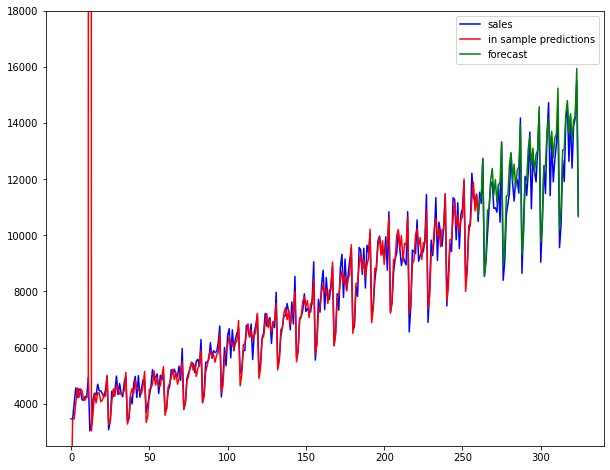

In [17]:
forecast=np.exp(res.predict(start=260,end=324,signal_only=True,dynamic=True))
preds = np.exp(res.predict(start=0,end=260))

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(dataSet.index,dataSet['sales'],label='sales',color='blue')
ax.plot(preds,label='in sample predictions',color='red')
ax.plot(forecast,label='forecast',color='green')
ax.set_ylim(2500, 18000)
plt.legend()
plt.show()

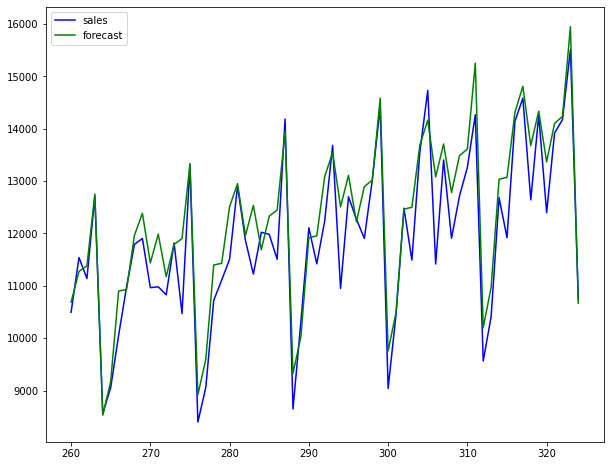

In [18]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(testData.index,testData['sales'],label='sales',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

#4. Comparación del modelo con TBATS

In [19]:
pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from tbats import TBATS, BATS# Fit the model
estimator = TBATS(seasonal_periods=(12, 65))
model = estimator.fit(trainData['sales'])

In [33]:
y_forecast = model.forecast(steps=65)

In [34]:
y_preds = model.y_hat

In [35]:
fore = pd.DataFrame()
fore['forecast']=y_forecast
fore.set_index(np.arange(259,259+65),inplace=True)

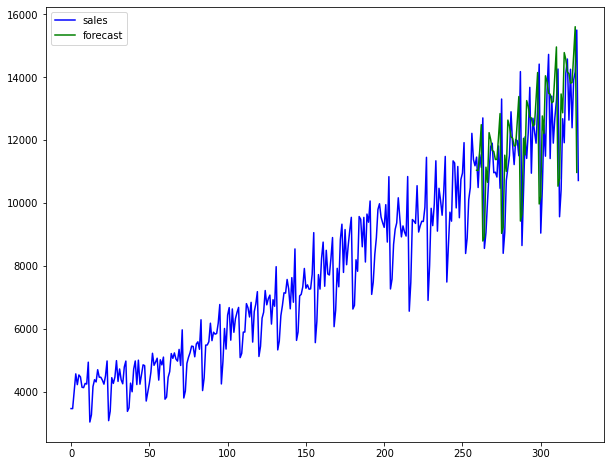

In [36]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(dataSet.index,dataSet['sales'],label='sales',color='blue')
ax.plot(fore.index,fore['forecast'],label='forecast',color='green')
plt.legend()
plt.show()

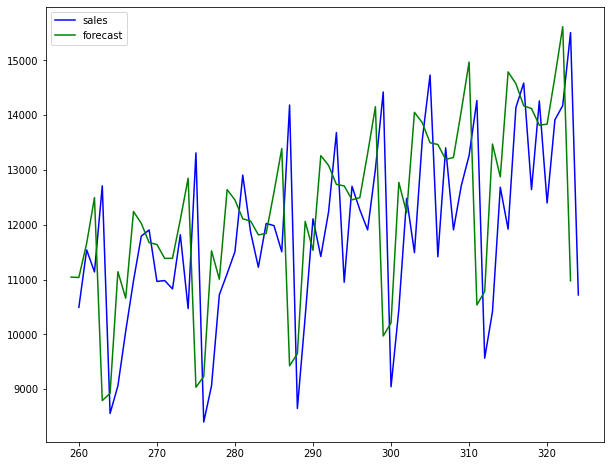

In [38]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(testData.index,testData['sales'],label='sales',color='blue')
ax.plot(fore.index,fore['forecast'],label='forecast',color='green')
plt.legend()
plt.show()

In [37]:
mae_arima = mean_absolute_error(testData['sales'], forecast)
mae_tbats = mean_absolute_error(testData['sales'], y_forecast)

print('MAE Arima: ', mae_arima)
print('MAE Tbats:',mae_tbats)

MAE Arima:  481.3768825010934
MAE Tbats: 589.6828659651127
